In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from scipy.optimize import curve_fit
import os
import time

In [30]:
# Автооглавление README

file = open("../README.md")

lines = file.readlines()

contents = "# Содержание\n\n"
counters = [0] * 4
level = 0

for line in lines:
    if not line.startswith("#") or line == "# Содержание\n":
        continue

    cur_level = 0
    while (cur_level + 1) < len(line) and line[cur_level + 1] == "#":
        cur_level += 1

    if cur_level >= len(counters):
        print("Error. More counters needed")

    if cur_level < level:
        for i in range(cur_level + 1, len(counters)):
            counters[i] = 0

    level = cur_level

    header = line[cur_level + 2:-1]

    link = "#" + header.lower().replace(" ", "-").replace("(", "").replace(")", "").replace(".", "").replace("`", "").replace(":","").replace("+", "")

    contents += "    " * cur_level + str(counters[cur_level] + 1) + ". [" + header + "](" + link + ")\n"
    counters[cur_level] += 1

print(contents)

# Содержание

1. [Оптимизация хеш таблицы](#оптимизация-хеш-таблицы)
    1. [Сравнение хеш-функций](#сравнение-хеш-функций)
        1. [Замечание о циклических сдвигах](#замечание-о-циклических-сдвигах)
    2. [Оптимизации](#оптимизации)
    3. [Варианты программы:](#варианты-программы)
        1. [1. `debug` - дебаг версия без оптимизаций](#1-debug---дебаг-версия-без-оптимизаций)
        2. [2. `base` - базовая версия без оптимизаций](#2-base---базовая-версия-без-оптимизаций)
        3. [3. `crc` - оптимизация подсчёта хеша](#3-crc---оптимизация-подсчёта-хеша)
        4. [4. `crc + cmp` - предыдущее + оптимизация сравнения строк](#4-crc--cmp---предыдущее--оптимизация-сравнения-строк)
    4. [Итоговые измерения](#итоговые-измерения)
    5. [Вывод](#вывод)
2. [Источники и инструменты](#источники-и-инструменты)
3. [Благодарности](#благодарности)



In [2]:
def large_int_to_str(n):
    n = str(n)

    res = ""

    for i in range(len(n)):
        if i != 0 and i % 3 == 0:
            res += "&nbsp;"[::-1]
        res += n[-1 - i]

    return res[::-1]

In [3]:
results = [[4202499,  4027318],
           [1846045,  967702 + 766607],
           [1254767,  743307 + 399714],
           [1040748,  529287 + 399714]]

names = ["debug", "base", "crc", "crc + cmp"]

print("""
<table>
    <thead>
        <tr>
            <th rowspan=2>Оптимизация</th>
            <th colspan=3 style="text-align: center">Вся программа</th>
            <th colspan=3 style="text-align: center">Функция поиска</th>
        </tr>
        <tr>
            <th style="text-align: center">Ir * 10^3</th>
            <th style="text-align: center">% от base</th>
            <th style="text-align: center">% от предыдущего</th>
            <th style="text-align: center">Ir * 10^3</th>
            <th style="text-align: center">% от base</th>
            <th style="text-align: center">% от предыдущего</th>
        </tr>
    </thead>
    <tbody>""")

for i in range(len(results)):
    print(" " * 8 + "<tr>")
    print(" " * 12 + "<td>" + names[i] + "</td>")

    for j in range(2):
        print(" " * 12 + "<td style=\"text-align: center\">" + large_int_to_str(results[i][j]) + "</td>")

        from_base = str(round(results[i][j] / results[1][j] * 100)) + "%"

        if i != 0:
            from_prev = str(round(results[i][j] / results[i - 1][j] * 100)) + "%"
        else:
            from_prev = ""

        print(" " * 12 + "<td style=\"text-align: center\">" + from_base + "</td>")
        print(" " * 12 + "<td style=\"text-align: center\">" + from_prev + "</td>")

print("""    </tbody>
</table>""")



<table>
    <thead>
        <tr>
            <th rowspan=2>Оптимизация</th>
            <th colspan=3 style="text-align: center">Вся программа</th>
            <th colspan=3 style="text-align: center">Функция поиска</th>
        </tr>
        <tr>
            <th style="text-align: center">Ir * 10^3</th>
            <th style="text-align: center">% от base</th>
            <th style="text-align: center">% от предыдущего</th>
            <th style="text-align: center">Ir * 10^3</th>
            <th style="text-align: center">% от base</th>
            <th style="text-align: center">% от предыдущего</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>debug</td>
            <td style="text-align: center">4&nbsp;202&nbsp;499</td>
            <td style="text-align: center">228%</td>
            <td style="text-align: center"></td>
            <td style="text-align: center">4&nbsp;027&nbsp;318</td>
            <td style="text-align: center">232%</td>
            <td sty

[4202499, 4027318, 1846045, 1734309, 1254767, 1143021, 1040748, 929001]


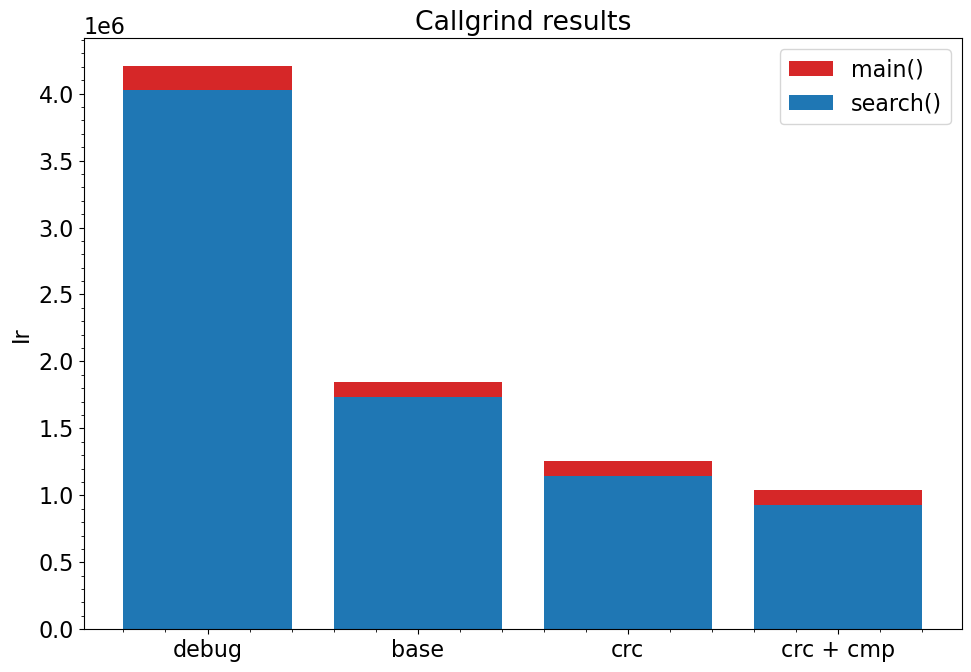

In [6]:
mpl.rcParams['font.size'] = 16
plt.figure(figsize = (10,7), facecolor = "white")

labels = []
for i in names:
    labels.append(" ")
    labels.append(i)
    labels.append(" ")
y = [y_ for y__ in results for y_ in y__]

print(y)

bar_colors = ['tab:red', 'tab:blue']

bars = []
for i in range(len(y)):
    bars.append(plt.bar(names[i // 2], y[i], color = bar_colors[i % 2]))

    #if i % 2 == 0:
        #bars.append(plt.bar(names[i // 2], 1000000, width = 0.000001, visible = False))

plt.legend(["main()", "search()"], loc='upper right')

plt.ylabel("Ir")
plt.title("Callgrind results")

plt.minorticks_on()
plt.tight_layout()

plt.savefig("../img/perf_bar_chart.png")
plt.show()